In [1]:
from typing import Any
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader

from anomalib import TaskType
from anomalib.data import MVTec, PredictDataset
from anomalib.data.utils import read_image
from anomalib.deploy import ExportType, OpenVINOInferencer
from anomalib.engine import Engine
from anomalib.models import Patchcore, EfficientAd
from anomalib.utils.post_processing import superimpose_anomaly_map

dataset_root = Path.cwd().parent / "assignment_2b" / "datasets" / "MVTec"

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datamodule = MVTec(num_workers=0, category='tile')
datamodule.prepare_data()
datamodule.setup()

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys()) 

dict_keys(['image_path', 'label', 'image', 'mask'])


In [3]:
print(data['image'].shape, data['mask'].shape)

torch.Size([32, 3, 840, 840]) torch.Size([32, 840, 840])


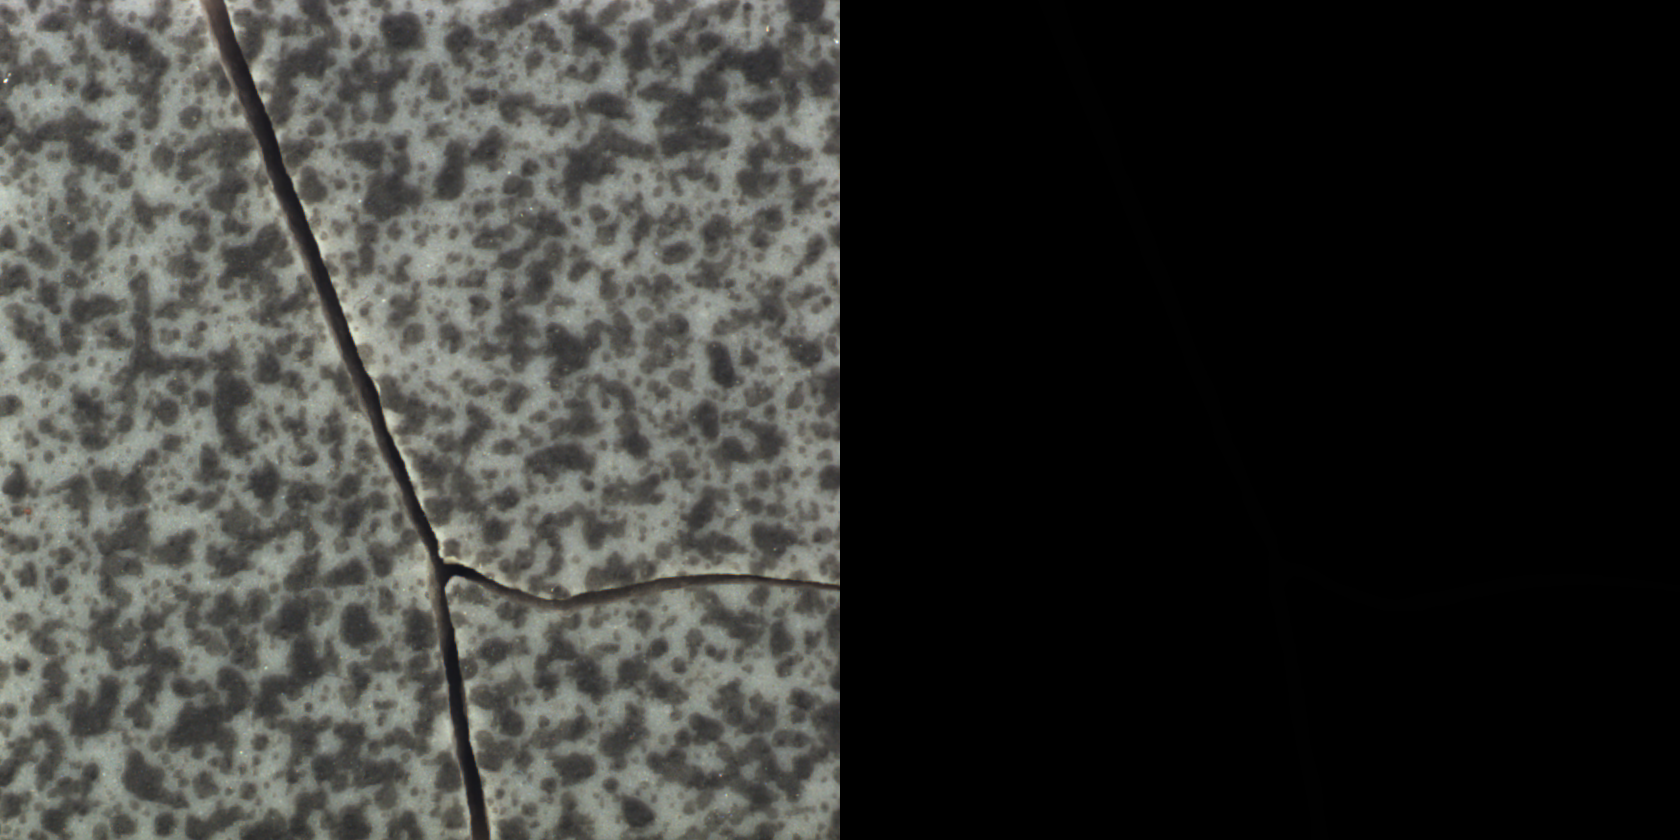

In [4]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    """Show an image with a mask.

    Args:
        sample (dict[str, Any]): Sample from the dataset.
        index (int): Index of the sample.

    Returns:
        Image: Output image with a mask.
    """
    # Load the image from the path
    image = Image.open(sample["image_path"][index])

    # Load the mask and convert it to RGB
    mask = ToPILImage()(sample["mask"][index]).convert("RGB")

    # Resize mask to match image size, if they differ
    if image.size != mask.size:
        mask = mask.resize(image.size)

    return Image.fromarray(np.hstack((np.array(image), np.array(mask))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

PatchCore is an innovative approach to anomaly detection that leverages the concept of patches from images or data. Here’s a high-level overview of how it works:

1. Patch Extraction: The model divides input images into smaller regions or "patches." This allows it to analyze local structures and patterns rather than the entire image, which can be beneficial for identifying anomalies.

2. Feature Representation: Each patch is transformed into a feature vector using a pre-trained convolutional neural network (CNN). This captures essential characteristics of the patches, making it easier to compare them.

3. Memory Bank: PatchCore maintains a memory bank of feature vectors from patches that are considered normal (from a training dataset). This memory serves as a reference for detecting anomalies.

4. Anomaly Scoring: When new data (or patches) are inputted into the model, their feature vectors are compared against the memory bank. An anomaly score is computed based on the distance from these reference vectors. Patches that significantly differ from the stored normal patches receive higher anomaly scores.

5. Thresholding: A threshold is applied to determine whether a patch is classified as an anomaly. If the score exceeds this threshold, it is flagged as an anomalous patch.

6. Final Decision: The model aggregates the anomaly scores across all patches to make a final decision about whether the entire image contains anomalies.

Overall, PatchCore is effective because it focuses on local information and maintains a robust reference of normal behavior, making it adept at detecting subtle anomalies in various contexts, such as medical imaging or industrial applications.

Here is the link to the paper for further details: https://arxiv.org/abs/2106.08265


In PatchCore, the concept of coresets plays a crucial role in enhancing the efficiency and effectiveness of anomaly detection. Here's how coreset functions within the model:

1. Efficient Representation: Coresets provide a compact representation of the large set of normal patches. Instead of maintaining and comparing all patches in the memory bank, a coreset reduces the number of stored patches while still capturing the essential characteristics of the dataset.

2. Representative Subset: The coreset is selected based on the diversity of the patches. It aims to include representative samples that cover the variation present in the normal patches, which helps the model generalize better to new data.

3. Distance Computation: By using the coreset, the model can significantly speed up the distance computations when assessing whether new patches are anomalous. Instead of comparing against all normal patches, it only needs to compare against the coreset, which reduces computational overhead.

4. Robustness: Coresets help improve the robustness of the anomaly detection process. By focusing on a smaller, more representative set of normal patches, the model can better identify deviations that genuinely indicate anomalies.

Overall, coreset selection is a key strategy in PatchCore that balances performance and computational efficiency, enabling the model to effectively detect anomalies without being overwhelmed by the volume of data.

Both Patchcore and EfficientAD methods are designed for one category anomaly detection tasks, known as cold-start or One-Class Classification(OOC). Hence we train one model per cetegory.

In [5]:
# Get the model and datamodule
model_patchcore_tile = Patchcore()
model_patchcore_tile.configure_transforms()
datamodule_tile = MVTec(num_workers=0, category='tile')
#Start  training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model_patchcore_tile, datamodule=datamodule_tile)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name           

Epoch 0:  12%|█▎        | 1/8 [00:01<00:07,  0.93it/s]

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\loops\optimization\automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 0: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]









































































































































































































































































































































































































































































































































































































Selecting Coreset Indices.: 100%|██████████| 18032/18032 [00:59<00:00, 302.92it/s]


Epoch 0: 100%|██████████| 8/8 [01:11<00:00,  0.11it/s, pixel_AUROC=0.502, pixel_F1Score=0.153]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 8/8 [01:12<00:00,  0.11it/s, pixel_AUROC=0.502, pixel_F1Score=0.153]


In [6]:
# Load the best model from the checkpoint before evaluating
test_results_patchcore_tile = engine.test(
    model=model_patchcore_tile,
    datamodule=datamodule_tile,
    ckpt_path=engine.checkpoint_callback.best_model_path,
)

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\anomalib\engine\engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_pat

Testing DataLoader 0: 100%|██████████| 4/4 [00:22<00:00,  0.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9873737096786499     │
│       image_F1Score       │    0.9818181991577148     │
│        pixel_AUROC        │    0.9479528665542603     │
│       pixel_F1Score       │    0.6211720108985901     │
└───────────────────────────┴───────────────────────────┘

In [7]:
#TODO: Figure out the visualization part later
inference_dataset = PredictDataset(path=dataset_root / "tile/test/crack/000.png")
inference_dataloader = DataLoader(dataset=inference_dataset)

predictions = engine.predict(model = model_patchcore_tile, dataloaders=inference_dataloader)[0]

ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


predictions contain image, anomaly maps, predicted scores, labels and masks. These are all stored in a dictionary. We could check this by printing the prediction keys.

In [8]:
print(
    f'Image Shape: {predictions["image"].shape},\n'
    'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    'Predicted Mask Shape: {predictions["pred_masks"].shape}',
)

Image Shape: torch.Size([1, 3, 224, 224]),
Anomaly Map Shape: {predictions["anomaly_maps"].shape}, 
Predicted Mask Shape: {predictions["pred_masks"].shape}


Let's first show the input image. To do so, we will use image_path key from the predictions dictionary, and read the image from path. Note that predictions dictionary already contains image. However, this is the normalized image with pixel values between 0 and 1. We will use the original image to visualize the input image.

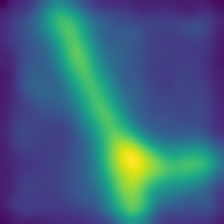

In [9]:
image_path = predictions["image_path"][0]
image_size = predictions["image"].shape[-2:]
image = np.array(Image.open(image_path).resize(image_size))

anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imsave("anomaly_map.png", anomaly_map)
Image.open("anomaly_map.png")

We could superimpose (overlay) the anomaly map on top of the original image to get a heat map. Anomalib has a built-in function to achieve this.

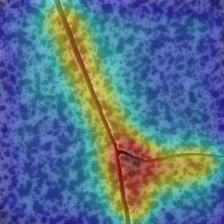

In [10]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imsave("heat_map.png", heat_map)
Image.open("heat_map.png")

predictions also contains prediction scores and labels.

In [11]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

tensor(1.) tensor(True)


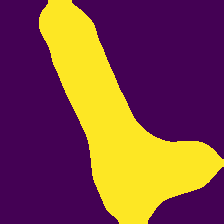

In [12]:
pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imsave("pred_mask.png", pred_masks)
Image.open("pred_mask.png")

In [13]:
# Get the model and datamodule
model_patchcore_leather = Patchcore()
datamodule_leather = MVTec(num_workers=0, category='leather')
#Start  training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model_patchcore_leather, datamodule=datamodule_leather)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1

Epoch 0: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


































































































































































































































































































































































































































































































































































































































































Selecting Coreset Indices.: 100%|██████████| 19208/19208 [01:05<00:00, 293.76it/s]


Epoch 0: 100%|██████████| 8/8 [01:26<00:00,  0.09it/s, pixel_AUROC=0.500, pixel_F1Score=0.0163]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 8/8 [01:26<00:00,  0.09it/s, pixel_AUROC=0.500, pixel_F1Score=0.0163]


In [14]:
# Load the best model from the checkpoint before evaluating
test_results_patchcore_leather = engine.test(
    model=model_patchcore_leather,
    datamodule=datamodule_leather,
    ckpt_path=engine.checkpoint_callback.best_model_path,
)

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\anomalib\engine\engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_pat

Testing DataLoader 0: 100%|██████████| 4/4 [00:25<00:00,  0.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │     0.994535505771637     │
│        pixel_AUROC        │    0.9898566007614136     │
│       pixel_F1Score       │    0.4391017258167267     │
└───────────────────────────┴───────────────────────────┘

In [15]:
# Get the model and datamodule
model_patchcore_grid = Patchcore()
datamodule_grid = MVTec(num_workers=0, category='grid')
#Start  training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model_patchcore_grid, datamodule=datamodule_grid)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1

Epoch 0: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
































































































































































































































































































































































































































































































































































































































































































































































































Selecting Coreset Indices.: 100%|██████████| 20697/20697 [01:18<00:00, 264.02it/s]


Epoch 0: 100%|██████████| 9/9 [02:27<00:00,  0.06it/s, pixel_AUROC=0.524, pixel_F1Score=0.0165]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 9/9 [02:27<00:00,  0.06it/s, pixel_AUROC=0.524, pixel_F1Score=0.0165]


In [16]:
# Load the best model from the checkpoint before evaluating
test_results_patchcore_grid = engine.test(
    model=model_patchcore_grid,
    datamodule=datamodule_grid,
    ckpt_path=engine.checkpoint_callback.best_model_path,
)

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\anomalib\engine\engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_pat

Testing DataLoader 0: 100%|██████████| 3/3 [00:13<00:00,  0.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9832915663719177     │
│       image_F1Score       │    0.9734513163566589     │
│        pixel_AUROC        │    0.9799023270606995     │
│       pixel_F1Score       │    0.37869885563850403    │
└───────────────────────────┴───────────────────────────┘

In [17]:
test_results_patchcore_combined = [
    {
        'pixel_AUROC': (test_results_patchcore_tile[0]['pixel_AUROC'] + test_results_patchcore_leather[0]['pixel_AUROC'] + test_results_patchcore_grid[0]['pixel_AUROC']) / 3,
        'pixel_F1Score': (test_results_patchcore_tile[0]['pixel_F1Score'] + test_results_patchcore_leather[0]['pixel_F1Score'] + test_results_patchcore_grid[0]['pixel_F1Score']) / 3,
        'image_AUROC': (test_results_patchcore_tile[0]['image_AUROC'] + test_results_patchcore_leather[0]['image_AUROC'] + test_results_patchcore_grid[0]['image_AUROC']) / 3,
        'image_F1Score': (test_results_patchcore_tile[0]['image_F1Score'] + test_results_patchcore_leather[0]['image_F1Score'] + test_results_patchcore_grid[0]['image_F1Score']) / 3,
    }
]

In [18]:
test_results_patchcore_combined

[{'pixel_AUROC': 0.9725705981254578,
  'pixel_F1Score': 0.47965753078460693,
  'image_AUROC': 0.9902217586835226,
  'image_F1Score': 0.9832683404286703}]

## EfficientAD


EfficientAD is a state-of-the-art student-teacher based model for anomaly detection that focuses on balancing performance and efficiency. Here’s an overview of how it works:

1. Architecture: EfficientAD typically employs a backbone network (often a convolutional neural network) to extract features from input data. This feature extraction is crucial for identifying patterns and anomalies.

2. Anomaly Score Calculation: The model computes anomaly scores based on the learned representations. It often uses statistical methods or distance metrics to quantify how much a given input deviates from the expected normal behavior.

3. Contrastive Learning: EfficientAD leverages contrastive learning techniques to improve the quality of the learned feature representations. By contrasting normal and anomalous instances, the model enhances its ability to distinguish between normal and anomalous patterns.

4. Data Augmentation: The model can incorporate data augmentation techniques to create variations of the input data. This helps improve robustness and generalization, allowing the model to better adapt to different scenarios.

5. Coreset Selection: Similar to PatchCore, EfficientAD may utilize a coreset approach to focus on a representative subset of the normal data, improving efficiency during the anomaly detection process.

6. Thresholding and Decision Making: Once the anomaly scores are calculated, a threshold is applied to classify inputs as normal or anomalous. The threshold can be tuned based on the desired sensitivity and specificity of the detection.

Overall, EfficientAD is designed to be both effective in detecting anomalies and efficient in processing, making it suitable for applications in various domains, such as industrial monitoring, healthcare, and more. Its focus on feature learning and contrastive methods contributes to its robustness and accuracy.

Here is th elink to the paper for further details: https://arxiv.org/abs/2303.14535

In [19]:
# Get the model and datamodule
efficient_ad_tile = EfficientAd()
datamodule_tile = MVTec(num_workers=0, category='tile', train_batch_size=1)
#Start  training
engine = Engine(task=TaskType.SEGMENTATION, max_epochs=1)
engine.fit(model=efficient_ad_tile, datamodule=datamodule_tile)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\anomalib\models\image\efficient_ad\lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
c:\Users\harsh\anacond

Epoch 0:   0%|          | 0/230 [00:00<?, ?it/s] 


c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_st', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_ae', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_stae', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 0: 100%|██████████| 230/230 [00:23<00:00,  9.75it/s, train_st_step=11.80, train_ae_step=0.942, train_stae_step=0.000637, train_loss_step=12.70]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Epoch 0: 100%|██████████| 230/230 [00:34<00:00,  6.66it/s, train_st_step=11.80, train_ae_step=0.942, train_stae_step=0.000637, train_loss_step=12.70, pixel_AUROC=0.787, pixel_F1Score=0.477, train_st_epoch=12.80, train_ae_epoch=1.010, train_stae_epoch=0.000938, train_loss_epoch=13.90]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 230/230 [00:35<00:00,  6.51it/s, train_st_step=11.80, train_ae_step=0.942, train_stae_step=0.000637, train_loss_step=12.70, pixel_AUROC=0.787, pixel_F1Score=0.477, train_st_epoch=12.80, train_ae_epoch=1.010, train_stae_epoch=0.000938, train_loss_epoch=13.90]


In [20]:
# Load the best model from the checkpoint before evaluating
test_results__efficient_ad_tile = engine.test(
    model=efficient_ad_tile,
    datamodule=datamodule_tile,
    ckpt_path=engine.checkpoint_callback.best_model_path,
)

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\anomalib\engine\engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_pat

Testing DataLoader 0: 100%|██████████| 4/4 [00:22<00:00,  0.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9487735033035278     │
│       image_F1Score       │    0.9176470637321472     │
│        pixel_AUROC        │    0.7874189019203186     │
│       pixel_F1Score       │    0.5566543340682983     │
└───────────────────────────┴───────────────────────────┘

Now we will do the same for the other 2 categories(leather, grid)

In [21]:
efficient_ad_leather = EfficientAd()
datamodule_leather = MVTec(num_workers=0, category='leather', train_batch_size=1)
#Start  training
engine = Engine(task=TaskType.SEGMENTATION, max_epochs=1)
engine.fit(model=efficient_ad_leather, datamodule=datamodule_leather)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\anomalib\models\image\efficient_ad\lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
c:\Users\harsh\anacond

Epoch 0:   0%|          | 0/245 [00:00<?, ?it/s] 

Epoch 0:   0%|          | 1/245 [00:00<00:37,  6.44it/s]

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_st', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_ae', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_stae', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 0: 100%|██████████| 245/245 [00:24<00:00, 10.13it/s, train_st_step=19.30, train_ae_step=2.520, train_stae_step=0.0575, train_loss_step=21.90] 

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 0: 100%|██████████| 245/245 [00:36<00:00,  6.67it/s, train_st_step=19.30, train_ae_step=2.520, train_stae_step=0.0575, train_loss_step=21.90, pixel_AUROC=0.939, pixel_F1Score=0.252, train_st_epoch=10.30, train_ae_epoch=2.480, train_stae_epoch=0.0207, train_loss_epoch=12.80]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 245/245 [00:37<00:00,  6.60it/s, train_st_step=19.30, train_ae_step=2.520, train_stae_step=0.0575, train_loss_step=21.90, pixel_AUROC=0.939, pixel_F1Score=0.252, train_st_epoch=10.30, train_ae_epoch=2.480, train_stae_epoch=0.0207, train_loss_epoch=12.80]


In [22]:
# Load the best model from the checkpoint before evaluating
test_results__efficient_ad_leather = engine.test(
    model=efficient_ad_leather,
    datamodule=datamodule_leather,
    ckpt_path=engine.checkpoint_callback.best_model_path,
)

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\anomalib\engine\engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_pat

Testing DataLoader 0: 100%|██████████| 4/4 [00:26<00:00,  0.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9412363767623901     │
│       image_F1Score       │    0.9289617538452148     │
│        pixel_AUROC        │    0.9387022256851196     │
│       pixel_F1Score       │    0.5229589939117432     │
└───────────────────────────┴───────────────────────────┘

In [23]:
efficient_ad_grid = EfficientAd()
datamodule_grid = MVTec(num_workers=0, category='grid', train_batch_size=1)
#Start  training
engine = Engine(task=TaskType.SEGMENTATION, max_epochs=1)
engine.fit(model=efficient_ad_grid, datamodule=datamodule_grid)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\anomalib\models\image\efficient_ad\lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
c:\Users\harsh\anacond

Epoch 0:   0%|          | 0/264 [00:00<?, ?it/s] 


c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_st', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_ae', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_stae', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 0: 100%|██████████| 264/264 [00:22<00:00, 11.75it/s, train_st_step=8.040, train_ae_step=0.976, train_stae_step=0.00104, train_loss_step=9.010] 

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Epoch 0: 100%|██████████| 264/264 [00:27<00:00,  9.49it/s, train_st_step=8.040, train_ae_step=0.976, train_stae_step=0.00104, train_loss_step=9.010, pixel_AUROC=0.826, pixel_F1Score=0.0973, train_st_epoch=9.970, train_ae_epoch=1.010, train_stae_epoch=0.00126, train_loss_epoch=11.00]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 264/264 [00:28<00:00,  9.38it/s, train_st_step=8.040, train_ae_step=0.976, train_stae_step=0.00104, train_loss_step=9.010, pixel_AUROC=0.826, pixel_F1Score=0.0973, train_st_epoch=9.970, train_ae_epoch=1.010, train_stae_epoch=0.00126, train_loss_epoch=11.00]


In [24]:
# Load the best model from the checkpoint before evaluating
test_results__efficient_ad_grid = engine.test(
    model=efficient_ad_grid,
    datamodule=datamodule_grid,
    ckpt_path=engine.checkpoint_callback.best_model_path,
)

c:\Users\harsh\anaconda3\envs\ai_assignment_2\lib\site-packages\anomalib\engine\engine.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_pat

Testing DataLoader 0: 100%|██████████| 3/3 [00:14<00:00,  0.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.943191409111023     │
│       image_F1Score       │    0.9189189076423645     │
│        pixel_AUROC        │    0.8264521360397339     │
│       pixel_F1Score       │    0.27651435136795044    │
└───────────────────────────┴───────────────────────────┘

In [25]:
test_results_efficient_ad_combined = [
    {
        'pixel_AUROC': (test_results__efficient_ad_tile[0]['pixel_AUROC'] + test_results__efficient_ad_leather[0]['pixel_AUROC'] + test_results__efficient_ad_grid[0]['pixel_AUROC']) / 3,
        'pixel_F1Score': (test_results__efficient_ad_tile[0]['pixel_F1Score'] + test_results__efficient_ad_leather[0]['pixel_F1Score'] + test_results__efficient_ad_grid[0]['pixel_F1Score']) / 3,
        'image_AUROC': (test_results__efficient_ad_tile[0]['image_AUROC'] + test_results__efficient_ad_leather[0]['image_AUROC'] + test_results__efficient_ad_grid[0]['image_AUROC']) / 3,
        'image_F1Score': (test_results__efficient_ad_tile[0]['image_F1Score'] + test_results__efficient_ad_leather[0]['image_F1Score'] + test_results__efficient_ad_grid[0]['image_F1Score']) / 3,
    }
]

In [26]:
test_results_efficient_ad_combined

[{'pixel_AUROC': 0.8508577545483907,
  'pixel_F1Score': 0.452042559782664,
  'image_AUROC': 0.944400429725647,
  'image_F1Score': 0.9218425750732422}]

## Similarity Search

For Patchore, we will be extracting features from the feature extractor of the model and then use these features to find the most similar images in the dataset. We will use the cosine similarity metric to find the most similar images. The similarity search will help us identify images that are visually similar to the input image, which can be useful for various applications such as content-based image retrieval, recommendation systems, and more.

In [ ]:
# Trained Patchore tile model architecture, which we will use to extract features
model_patchcore_tile

Patchcore(
  (model): PatchcoreModel(
    (feature_extractor): TimmFeatureExtractor(
      (feature_extractor): FeatureListNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): ReLU(inplace=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (drop_block): Identity()
            (act2): ReLU(inplace=Tru

In [32]:
# Feature extractor
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()
    return hook

# Initialize the model
model = model_patchcore_tile.model

# # Make a hook to get the features
model.feature_pooler.register_forward_hook(get_activation('features'))


In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from torchvision.transforms import Resize
from tqdm import tqdm
import torch
qdrant = QdrantClient(":memory:") # Create in-memory Qdrant instance, for testing, CI/CD
model.eval()
# Create a collection or database of images where you store the feature vectors
my_collection = "image_collection"
qdrant.create_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=262144, distance=models.Distance.COSINE)
)
## Setting up the dataset for category tile, and getting the embeddings
dataset = MVTec(num_workers=0, category='tile')
dataset.prepare_data()
dataset.setup()

## Train embeddings
# batch_size = len(dataset.train_data)
batch_size = 1
ids = [k for k in range(0, len(dataset.train_data))]
train_embeddings = []
train_image_paths = []
for i in tqdm(range(0, len(dataset.train_data), batch_size)):
    low_idx = min(i + batch_size, len(dataset.train_data))

    batch_of_ids = ids[i:low_idx]
    batch_of_images = torch.stack([dataset.train_data[k]['image'] for k in batch_of_ids])
    batch_of_image_paths = [dataset.train_data[k]['image_path'] for k in batch_of_ids]
    image_tensors = Resize((256, 256))(batch_of_images)
    outputs = model(image_tensors)
    feature_vectors = activation['features'].detach().cpu().numpy().flatten()
    train_embeddings.append(feature_vectors)
    train_image_paths.extend(batch_of_image_paths)


train_embeddings = np.array(train_embeddings)
train_embeddings = train_embeddings.reshape(train_embeddings.shape[0], -1)
np.save("train_embeddings.npy", train_embeddings)
train_embeddings = train_embeddings.tolist()

## Validation embeddings
val_embeddings = []
val_image_paths = []
# batch_size = len(dataset.val_data)
batch_size = 1
ids = [k for k in range(0, len(dataset.val_data))]
for i in tqdm(range(0, len(dataset.val_data), batch_size)):
    low_idx = min(i + batch_size, len(dataset.val_data))

    batch_of_ids = ids[i:low_idx]
    batch_of_images = torch.stack([dataset.val_data[k]['image'] for k in batch_of_ids])
    batch_of_image_paths = [dataset.val_data[k]['image_path'] for k in batch_of_ids]
    image_tensors = Resize((256, 256))(batch_of_images)
    outputs = model(image_tensors)
    feature_vectors = activation['features'].detach().cpu().numpy().flatten()

    val_embeddings.append(feature_vectors)
    val_image_paths.extend(batch_of_image_paths)

val_embeddings = np.array(val_embeddings)
val_embeddings = val_embeddings.reshape(val_embeddings.shape[0], -1)
np.save("val_embeddings.npy", val_embeddings)
val_embeddings = val_embeddings.tolist()

100%|██████████| 117/117 [00:28<00:00,  4.05it/s]


In [ ]:
# Load the embeddings
import numpy as np
train_embeddings = np.load("train_embeddings.npy").tolist()
val_embeddings = np.load("val_embeddings.npy").tolist()

In [100]:
## Insert the train and test data into qdrant
for i in range(1, len(train_embeddings)):
    # ID is a 64 bit unsigned integer
    qdrant.upsert(
        collection_name=my_collection,
        points=[models.PointStruct(
            id=i,
            payload={
                "image_path": train_image_paths[i],
            },
            vector=train_embeddings[i],
        )],
    )
for i in range(1, len(val_embeddings)):
    qdrant.upsert(
        collection_name=my_collection,
        points=[models.PointStruct(
            id=len(train_embeddings) + i,
            payload={
                "image_path": val_image_paths[i],
            },
            vector=val_embeddings[i],
        )],
    )

In [101]:
qdrant.count(
    collection_name=my_collection,
    exact=True,
)

CountResult(count=345)

In [ ]:
# Query the collection
def search_image(image_path: str, model: torch.nn.Module, activation: dict, qdrant: QdrantClient, collection_name: str):
    image = plt.imread(image_path)
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    image_tensor = Resize((256, 256))(image_tensor)

    output = model(image_tensor)
    feature_vector = activation['features'].detach().cpu().numpy().flatten()

    query_vector = feature_vector.tolist()

    query_results = qdrant.search(
        collection_name=my_collection,
        query_vector=query_vector,
        limit=5,
    )
    
    return query_results

## Visualize the query results
def visualize_query_results(query_results: list[models.PointStruct], image_path: str):
    plt.subplots(1, 6, figsize=(20, 10))
    plt.subplot(1, 6, 1)
    plt.title("Original Image")
    original_image = plt.imread(image_path)
    plt.imshow(original_image)
    for i in range(5):
        image = plt.imread(query_results[i].payload['image_path'])
        plt.subplot(1, 6, i + 2)
        plt.title(f"Result {i + 1}, Score: {query_results[i].score:.2f}")
        plt.imshow(image)

    # Save image
    plt.savefig("query_results.png")
    return Image.open("query_results.png")

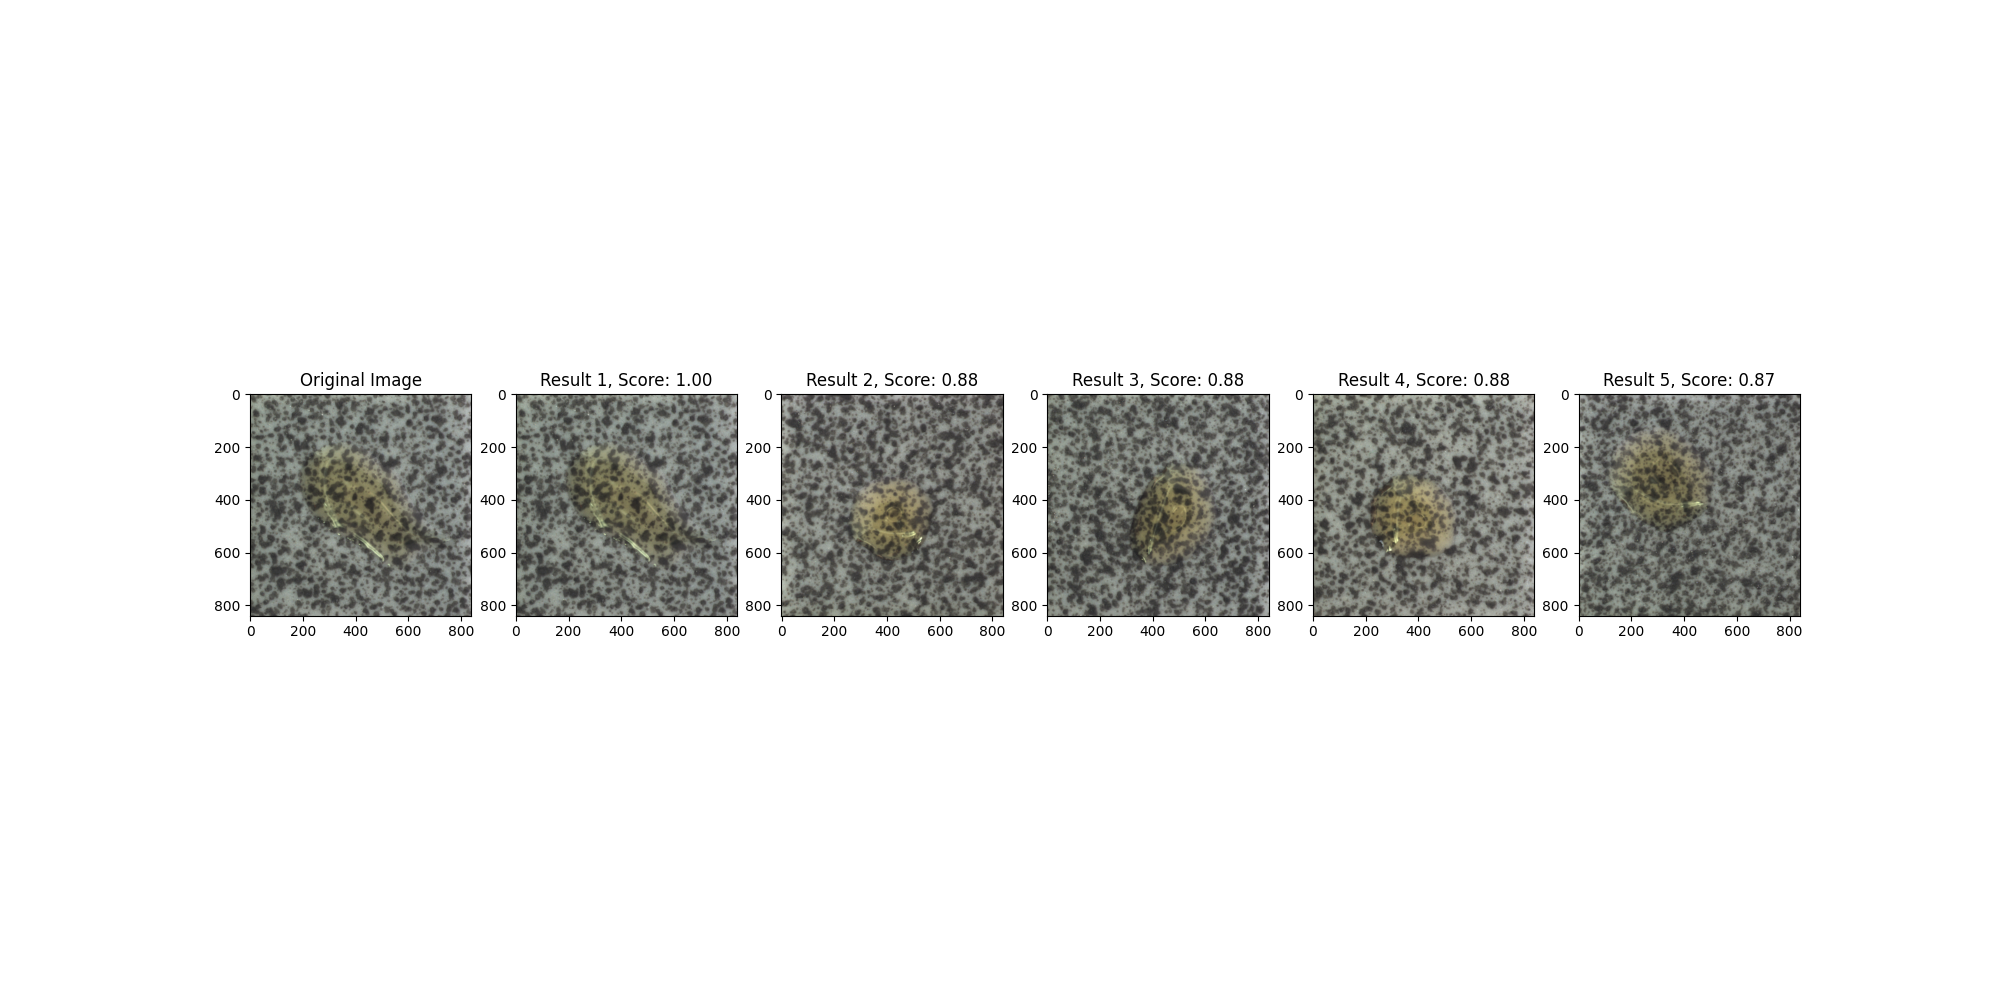

In [ ]:
## Here we visualize the Similarity search for a oil anomaly tile image
query_image_path = dataset_root / "tile/test/oil/000.png"
query_results = search_image(query_image_path, model, activation, qdrant, my_collection)
visualize_query_results(query_results, query_image_path)

In [115]:
query_image_path = dataset_root / "tile/test/crack/000.png"
query_results = search_image(query_image_path, model, activation, qdrant, my_collection)
print(query_results)

[ScoredPoint(id=244, version=0, score=0.8633559926099116, payload={'image_path': 'C:\\Users\\harsh\\Documents\\AI\\cs_gy_6613_assignments\\assignment_2b\\datasets\\MVTec\\tile/test/crack/014.png'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=237, version=0, score=0.8607258334595801, payload={'image_path': 'C:\\Users\\harsh\\Documents\\AI\\cs_gy_6613_assignments\\assignment_2b\\datasets\\MVTec\\tile/test/crack/007.png'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=242, version=0, score=0.847443841104726, payload={'image_path': 'C:\\Users\\harsh\\Documents\\AI\\cs_gy_6613_assignments\\assignment_2b\\datasets\\MVTec\\tile/test/crack/012.png'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=231, version=0, score=0.8289830102959894, payload={'image_path': 'C:\\Users\\harsh\\Documents\\AI\\cs_gy_6613_assignments\\assignment_2b\\datasets\\MVTec\\tile/test/crack/001.png'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=234, 

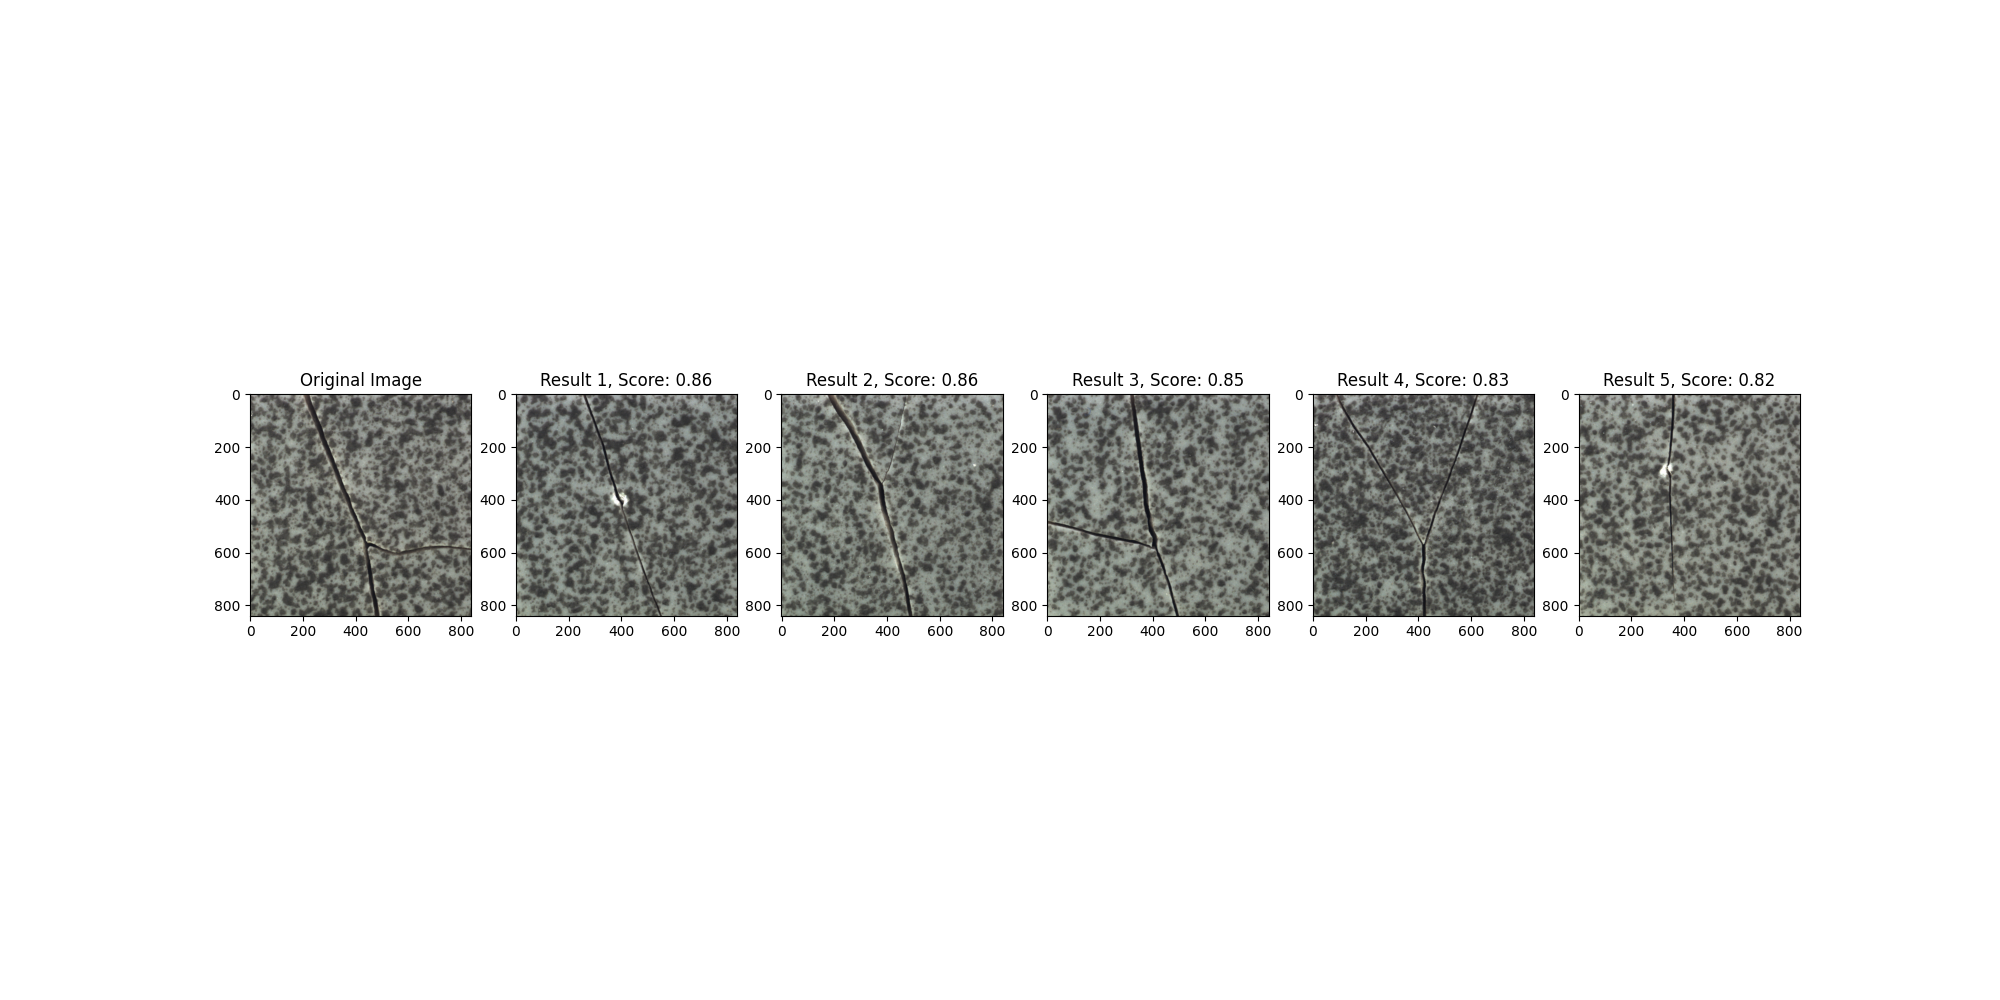

In [116]:
visualize_query_results(query_results, query_image_path)

As expected, the top 5 images are all having the same anomaly as the original iamge, the simialrity scores are reported on top of the images.

Now, let's try the simialrity search for EfficientAD

In [125]:
model

EfficientAdModel(
  (teacher): SmallPatchDescriptionNetwork(
    (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(256, 384, kernel_size=(4, 4), stride=(1, 1))
    (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (student): SmallPatchDescriptionNetwork(
    (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(256, 768, kernel_size=(4, 4), stride=(1, 1))
    (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (ae): AutoEncoder(
    (encoder): Encoder(
      (enconv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

In [128]:
# Initialize the model
model = efficient_ad_leather.model

# # Make a hook to get the features
model.student.register_forward_hook(get_activation('features'))


from qdrant_client import QdrantClient
from qdrant_client.http import models
from torchvision.transforms import Resize
from tqdm import tqdm
import torch
qdrant = QdrantClient(":memory:") # Create in-memory Qdrant instance, for testing, CI/CD
model.eval()
# Create a collection or database of images where you store the feature vectors
my_collection = "image_collection"
qdrant.create_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=1204224, distance=models.Distance.COSINE)
)
## Setting up the dataset for category grid, and getting the embeddings
dataset = MVTec(num_workers=0, category='grid')
dataset.prepare_data()
dataset.setup()

## Train embeddings
# batch_size = len(dataset.train_data)
batch_size = 1
ids = [k for k in range(0, len(dataset.train_data))]
train_embeddings = []
train_image_paths = []
for i in tqdm(range(0, len(dataset.train_data), batch_size)):
    low_idx = min(i + batch_size, len(dataset.train_data))

    batch_of_ids = ids[i:low_idx]
    batch_of_images = torch.stack([dataset.train_data[k]['image'] for k in batch_of_ids])
    batch_of_image_paths = [dataset.train_data[k]['image_path'] for k in batch_of_ids]
    image_tensors = Resize((256, 256))(batch_of_images)
    outputs = model(image_tensors)
    feature_vectors = activation['features'].detach().cpu().numpy().flatten()
    train_embeddings.append(feature_vectors)
    train_image_paths.extend(batch_of_image_paths)


train_embeddings = np.array(train_embeddings)
train_embeddings = train_embeddings.reshape(train_embeddings.shape[0], -1)
np.save("train_embeddings_efficient_ad.npy", train_embeddings)
train_embeddings = train_embeddings.tolist()

## Validation embeddings
val_embeddings = []
val_image_paths = []
# batch_size = len(dataset.val_data)
batch_size = 1
ids = [k for k in range(0, len(dataset.val_data))]
for i in tqdm(range(0, len(dataset.val_data), batch_size)):
    low_idx = min(i + batch_size, len(dataset.val_data))

    batch_of_ids = ids[i:low_idx]
    batch_of_images = torch.stack([dataset.val_data[k]['image'] for k in batch_of_ids])
    batch_of_image_paths = [dataset.val_data[k]['image_path'] for k in batch_of_ids]
    image_tensors = Resize((256, 256))(batch_of_images)
    outputs = model(image_tensors)
    feature_vectors = activation['features'].detach().cpu().numpy().flatten()

    val_embeddings.append(feature_vectors)
    val_image_paths.extend(batch_of_image_paths)

val_embeddings = np.array(val_embeddings)
val_embeddings = val_embeddings.reshape(val_embeddings.shape[0], -1)
np.save("val_embeddings_efficient_ad.npy", val_embeddings)
val_embeddings = val_embeddings.tolist()

# Load the embeddings
import numpy as np
train_embeddings = np.load("train_embeddings_efficient_ad.npy").tolist()
val_embeddings = np.load("val_embeddings_efficient_ad.npy").tolist()


## Insert the train and test data into qdrant
for i in range(1, len(train_embeddings)):
    # ID is a 64 bit unsigned integer
    qdrant.upsert(
        collection_name=my_collection,
        points=[models.PointStruct(
            id=i,
            payload={
                "image_path": train_image_paths[i],
            },
            vector=train_embeddings[i],
        )],
    )
for i in range(1, len(val_embeddings)):
    qdrant.upsert(
        collection_name=my_collection,
        points=[models.PointStruct(
            id=len(train_embeddings) + i,
            payload={
                "image_path": val_image_paths[i],
            },
            vector=val_embeddings[i],
        )],
    )




100%|██████████| 264/264 [01:06<00:00,  3.96it/s]


MemoryError: 

The features don't fit in my memory, hence the error, but everything is the same as PatchCore.

In [127]:
train_embeddings = np.array(train_embeddings)
train_embeddings.shape

(245, 1204224)

In [ ]:
## Here we visualize the Similarity search for a oil anomaly tile image
query_image_path = dataset_root / "leather/test/oil/000.png"
query_results = search_image(query_image_path, model, activation, qdrant, my_collection)
visualize_query_results(query_results, query_image_path)